In [1]:
#Scrappe all companies
#!parallel -j10 --progress  wget -P companies https://www.ycombinator.com/companies/{} ::: `seq 2000`

In [2]:
#make gender dictionary (from https://data.world/howarder/gender-by-name# )
#!wget https://query.data.world/s/elahhcphnphgcjetadzjj4flvvcyjd

import pandas as pd
names=pd.read_csv('name_gender.csv')

import csv
names={}
with open('name_gender.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        names[row['name'].lower()]=[row['gender'],row['probability']]
print("%i names with genders loaded."%len(names))

95026 names with genders loaded.


In [3]:
def get_gender(name):
    name=name.split()[0].lower()
    if name in names.keys():
        return names[name][0]
    else:
        return None
get_gender('Emma Sanchez')

'F'

In [4]:
from bs4 import BeautifulSoup
company_html = "companies/*"

def get_founders(company_html):
    content =open(company_html, "r",encoding="mbcs").read()
    soup = BeautifulSoup(content)
    title=soup.title.text.split('|')[0].rstrip()

    founders_div = soup.find_all("div", class_="founder-card")
    founders=[]
    genders=[]
    
    batch = soup.find("i", class_="fa-y-combinator").parent.text
    batch = int(batch[1:]) if 'S' in batch else 0.5+int(batch[1:]) #convert to float
    for founder_div in founders_div:
        founders.append(founder_div.find("div", class_="heavy").text)
        genders.append(get_gender(founders[-1]))
    if len(founders)==0:
        founders.append(None)
        genders.append(None)
        #print("%s has no founders."%title)
    return title,founders,genders,batch

company_html = "companies/12"
get_founders(company_html)

('Hipmob', ['Olufemi Omojola'], ['M'], 12.5)

In [5]:
import concurrent.futures
import glob
from tqdm import tqdm

companies_html=glob.glob('companies/*')
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    # map
    l = list(tqdm(
        executor.map(
            lambda company_html: get_founders(company_html), companies_html
        ), total=len(companies_html)))

print('Done.')

100%|██████████| 1646/1646 [00:24<00:00, 66.59it/s]Done.



In [6]:
df = pd.DataFrame(l) 
df.columns = ['Company', 'Names', 'Genders', 'Batch']
df

,Company,Names,Genders,Batch
0,The Muse,"[Alex Cavoulacos, Kathryn Minshew]","[M, F]",12.5
1,MarketBrief,[Chris Auer],[M],11.0
2,Loop Genomics,[Tuval Ben-Yehezkel],[None],16.5
3,Toymail,[Gauri Nanda],[F],16.5
4,UpLabs,[Matt Dellac],[M],16.5
...,...,...,...,...
1641,Petcube,"[Andrey Klen, Alex Neskin, Yaroslav Azhnyuk]","[M, M, M]",16.5
1642,Daily,[Kwindla Hultman Kramer],[None],16.5
1643,Mio,"[James Cundle, Tom Hadfield]","[M, M]",16.5
1644,Algoriz,[Soraya Taghavi],[F],16.5


In [7]:
df['F_ratio'] = df.apply(lambda x: x['Genders'].count('F')/(len(x['Genders'])) ,axis=1)
df['N_Founders'] = df.apply(lambda x: 0 if x['Names']==[None] else len(x['Names']) ,axis=1)
df

,Company,Names,Genders,Batch,F_ratio,N_Founders
0,The Muse,"[Alex Cavoulacos, Kathryn Minshew]","[M, F]",12.5,0.5,2
1,MarketBrief,[Chris Auer],[M],11.0,0.0,1
2,Loop Genomics,[Tuval Ben-Yehezkel],[None],16.5,0.0,1
3,Toymail,[Gauri Nanda],[F],16.5,1.0,1
4,UpLabs,[Matt Dellac],[M],16.5,0.0,1
...,...,...,...,...,...,...
1641,Petcube,"[Andrey Klen, Alex Neskin, Yaroslav Azhnyuk]","[M, M, M]",16.5,0.0,3
1642,Daily,[Kwindla Hultman Kramer],[None],16.5,0.0,1
1643,Mio,"[James Cundle, Tom Hadfield]","[M, M]",16.5,0.0,2
1644,Algoriz,[Soraya Taghavi],[F],16.5,1.0,1


In [8]:
df.iloc[11]

Company               Copia
Names         [Komal Ahmad]
Genders                 [F]
Batch                  16.5
F_ratio                   1
N_Founders                1
Name: 11, dtype: object

In [9]:
df[df['N_Founders']>0].mean()

Batch         15.172700
F_ratio        0.127350
N_Founders     1.817496
dtype: float64

In [10]:
import numpy as np
df_batches = df.groupby("Batch").agg([np.mean, np.std, len])
df_batches.head()

F_ratio                 N_Founders              
           mean       std   len       mean       std len
Batch                                                   
5.0    0.000000  0.000000  10.0   0.600000  0.699206  10
6.0    0.113636  0.303390  11.0   1.090909  1.136182  11
6.5    0.000000  0.000000   7.0   0.857143  0.690066   7
7.0    0.026316  0.114708  19.0   1.315789  0.885226  19
7.5    0.038462  0.138675  13.0   0.769231  1.363442  13

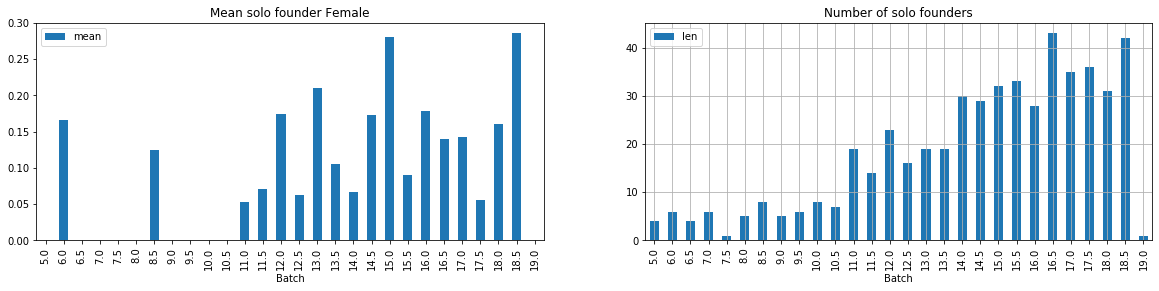

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(20, 4))
df[df['N_Founders']==1].groupby("Batch").agg([np.mean])['F_ratio'].plot(kind = "bar", y = ["mean"], 
            title = "Mean solo founder Female", ax=ax[0])
df[df['N_Founders']==1].groupby("Batch").agg([len])['F_ratio'].plot(kind = "bar", y = ["len"], 
            title = "Number of solo founders", grid=True, ax=ax[1])

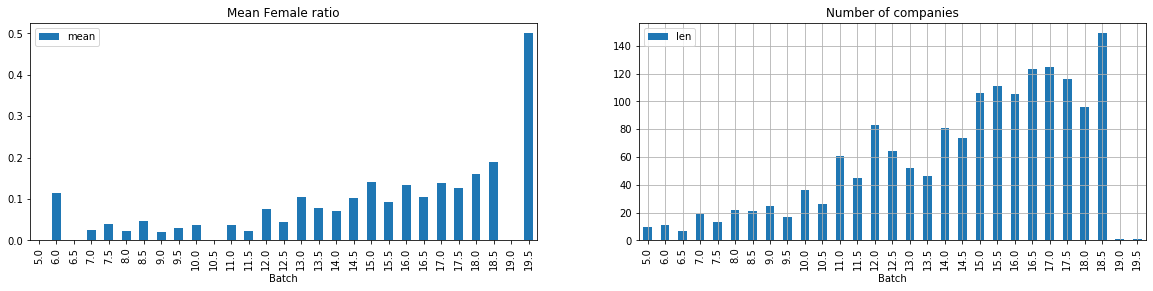

In [12]:
fig, ax = plt.subplots(1,2, figsize=(20, 4))
df.groupby("Batch").agg([np.mean])['F_ratio'].plot(kind = "bar", y = ["mean"], 
            title = "Mean Female ratio", ax=ax[0])
df.groupby("Batch").agg([len])['F_ratio'].plot(kind = "bar", y = ["len"], 
            title = "Number of companies", grid=True, ax=ax[1])

In [13]:
f=df[(df['N_Founders']==1)&(df['F_ratio']==1)].groupby('Batch')['F_ratio'].count()

In [14]:
t=df[(df['N_Founders']==1)].groupby('Batch')['F_ratio'].count()

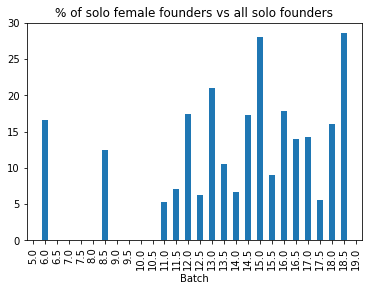

In [15]:
r=f/t*100
r.plot(title='% of solo female founders vs all solo founders',kind='bar')

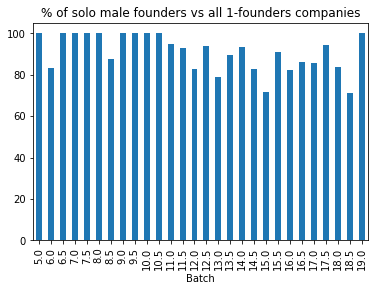

In [16]:
f=df[(df['N_Founders']==1)&(df['F_ratio']==0)].groupby('Batch')['F_ratio'].count()
t=df[(df['N_Founders']==1)].groupby('Batch')['F_ratio'].count()
r=f/t*100
r.plot(title='% of solo male founders vs all 1-founders companies',kind='bar')

In [17]:
df[(df['N_Founders']==1)&(df['F_ratio']==0)]['N_Founders'].sum()/\
df[(df['N_Founders']==1)]['N_Founders'].sum()

0.8647058823529412

In [18]:
df[(df['F_ratio']==1) & (df['N_Founders']==1)]

,Company,Names,Genders,Batch,F_ratio,N_Founders
3,Toymail,[Gauri Nanda],[F],16.5,1.0,1
11,Copia,[Komal Ahmad],[F],16.5,1.0,1
38,Netomi,[Puneet Mehta],[F],16.5,1.0,1
44,Embark,[Taylor Malloy],[F],11.0,1.0,1
71,Georgette Packaging,[Sarah Landstreet],[F],16.5,1.0,1
...,...,...,...,...,...,...
1561,zPREDICTA,[Julia Kirshner],[F],15.0,1.0,1
1592,HER,[Robyn Exton],[F],15.0,1.0,1
1604,StyleBee,[Anna Santeramo],[F],15.0,1.0,1
1612,Vive,[Alanna Gregory],[F],15.0,1.0,1


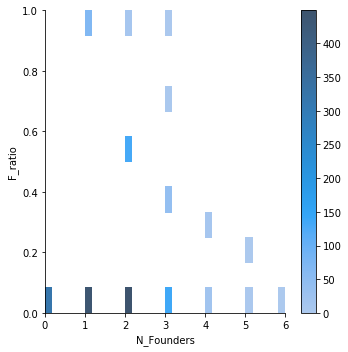

In [19]:
import seaborn as sns
sns.displot(df,x='N_Founders',y='F_ratio', cbar=True,palette='Dark2')

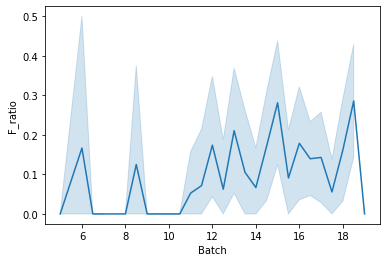

In [20]:
from numpy import median
sns.lineplot(
        data=df[df['N_Founders']==1], x="Batch", y="F_ratio")

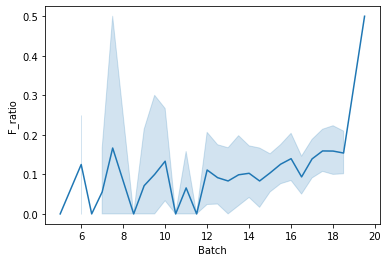

In [21]:
sns.lineplot(
        data=df[df['N_Founders']>1], x="Batch", y="F_ratio")

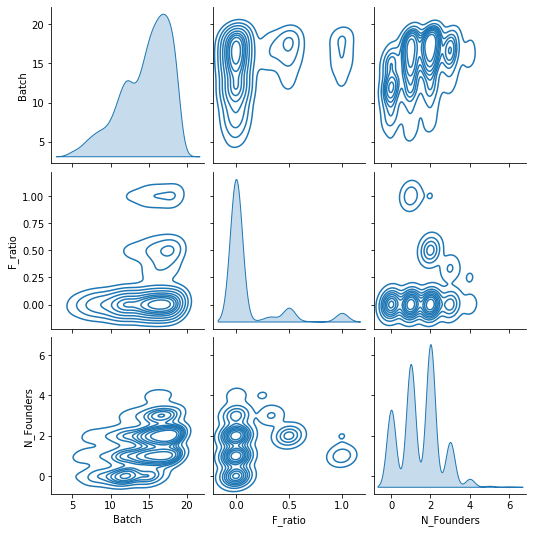

In [22]:
sns.pairplot(df,kind='kde')

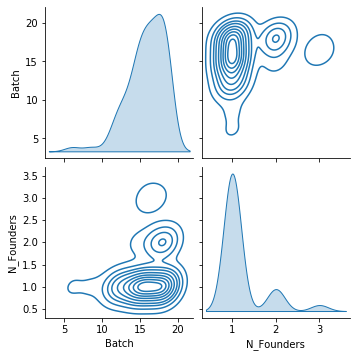

In [23]:
sns.pairplot(df[df['F_ratio']==1][['Batch','N_Founders']],kind='kde')

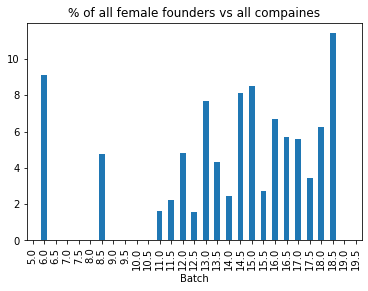

In [24]:
f=df[df['F_ratio']==1].groupby('Batch')['F_ratio'].count()
t=df.groupby('Batch')['F_ratio'].count()
r=f/t*100
r.plot(title='% of all female founders vs all compaines',kind='bar')

In [25]:
len(df[df['F_ratio']==1]),len(df[(df['F_ratio']==1)&(df['N_Founders']>1)])

(83, 14)

In [26]:
df.apply(lambda x: x['Genders'].count('M') ,axis=1).sum(),\
df.apply(lambda x: x['Genders'].count('F') ,axis=1).sum(),\


(1884, 295)